In [1]:
import pandas as pd
import numpy as np
import random
import string

In [19]:
def select_words(file, l):
    #takes parameters file and l, returns words in file that only have a length=l.
    #accounts for the fact that our word list has \n after every word, and corrects this data error.
    with open(file) as f:
         lis = f.readlines()
    
    new = np.array([])
    for word in lis:
        word = word[:-1]
        if len(word) == l:
            new = np.append(new, word)
    return new
    
word_array = select_words('Data/wordle_words.txt', 5)

guess_array =  select_words('Data/english_words_full.txt', 5)

In [20]:
def replace_char(word, char, index):
    l_word = list(word)
    l_word[index] = char
    return "".join(l_word)


HALF_CORRECT = 1
FULL_CORRECT = 2
INCORRECT = 0

class Squabble:
    
    #creates a squabble game, parameters are self-evident.
    def __init__(self, solution, word_array, max_guesses=6):
        self.solution = str.lower(solution)
        self.word_array = word_array
        self.max_guesses = max_guesses
        self.guess_count = 0
        self.guesses = np.array([])
        self.solved = False

    """ 
    adds a guess to the list of guesses
    returns an array of numbers, each item in the array corresponds to a character, in order.
     NOTHING = not in word (Gray), 
     HALF_CORRECT = in word but wrong spot (Yellow), 
     FULL_CORRECT = in word and in correct place (Green)
    """
    def guess(self, guess):
        guess = str.lower(guess)
        self.guesses = np.append(self.guesses, guess)
        self.guess_count += 1

        #if our guess isnt a viable word, we return None
        #if not guess in word_array:
        #    return None

        #return list of FULL_CORRECT if we guessed the solution
        if guess == self.solution or self.guess_count >= self.max_guesses:
            self.solved = True
        #if we didnt get it correct, and we are out of guesses 

        guess_values = [INCORRECT for i in range(len(self.solution))]
        temp_solution = self.solution

        #sets our green letters == FULL_CORRECT
        #removes green letters from the solution so that we don't have errors
        for i in range(len(self.solution)):
            if temp_solution[i] == guess[i]:
                temp_solution = replace_char(temp_solution, ' ', i)
                guess_values[i] = FULL_CORRECT

        #sets our yellow letters == HALF_CORRECT
        #removes yellow letters from solution so that we dont have repeating yellows
        for i in range(len(guess)):
            if guess[i] in temp_solution and not guess_values[i] == FULL_CORRECT:
                guess_values[i] = HALF_CORRECT
                temp_solution = replace_char(temp_solution, ' ', temp_solution.find(guess[i]))
        return guess_values

In [21]:
"""
next guess is used to calculate the best next guesses, and it ranks them for you :)
     0 means letter is gray, and final word will nto contain it
     1 means letter is yellow, final word has letter but not in that spot
     2 means letter is green, final word has that letter in that position
word_array is all available words
"""
def next_guess(guess, values, avail_words):
    if len(guess) != len(values):
        raise BaseException
    
    guess = list(guess)

    for i in range(len(guess)):
        values[i] = int(values[i])
        guess[i] = str(guess[i])

        if values[i] != 0 :
            avail_words = reduce_word_array(avail_words, values[i], guess[i], i)
        elif det_mult_char(guess.copy(), values.copy(), i):
            avail_words = reduce_word_array(avail_words, values[i], guess[i], i)
        else:
            avail_words = reduce_word_array(avail_words, 3, guess[i], i)

    return get_rankings(avail_words), avail_words

"""
this function determines if there are multiple of the same characters, and one of them is green/yellow
if there are, it will return FALSE if one of them is green/yellow,
otherwise (meaning they are all grey) it will return TRUE
this is useful so we dont delete words that contain a green/yellow char just because it is
grey in one location
"""
def det_mult_char(chars, values, i):
    char = chars[i]
    indexes = []
    for ind, x in enumerate(chars):
        if char == x:
            indexes.append(ind)

    if(len(indexes) == 1):
        return True

    all_grey = True
    for ind in indexes:
        if values[ind] != 0:
            all_grey = False
            break

    return all_grey


"""
reduce word array reduces the available words to help calculation
reduce type is the type of reduction: 0 = grey   : word cannot contain it
                                      1 = yellow : char in word but not in current index
                                      2 = green  : char in word at index
                                      3 = special grey: char not in word at that index
"""
def reduce_word_array(avail_words, reduce_type, char, index=-1):
    deleters = []
    if reduce_type == 0: #grey
        for i, word in enumerate(avail_words):
            if char in word:
                deleters.append(i)
    if reduce_type == 1: # yellow
        for i, word in enumerate(avail_words):
            if word[index] == char or not char in word:
                deleters.append(i)
    if reduce_type == 2: #green
        for i, word in enumerate(avail_words):
            if word[index] != char:
                deleters.append(i)
    if reduce_type == 3: #special grey
        for i, word in enumerate(avail_words):
            if word[index] == char:
                deleters.append(i)
    avail_words = np.delete(avail_words, deleters)
    return avail_words



"""
Better word score takes in a word and returns how much value it has
Useful for finding best guess
"""
def better_word_score(word, char_val):
    total = 0
    dead = []
    for char in word:
        if not char in dead:
            dead.append(char)
            total += char_val[char]
    return total

"""
Sort rankings takes a list of values and words
sorts them to help find best guesses
"""
def sort_rankings(rankings, words):
    df = pd.DataFrame()
    df = df.assign(word=words)
    df = df.assign(value=rankings)
    return df.set_index('word').sort_values(by='value', ascending=False)

"""
ranks all words based on the value of characters
"""
def get_word_rankings(words, alphabet_value):
    word_value = np.array([])
    for word in words:
        word_value = np.append(word_value, better_word_score(word, alphabet_value))
    return word_value

"""
ranks all characters based on their frequency
"""
def get_alphabet_value(words):
    alphabet = list(string.ascii_lowercase)
    alphabet_count = {}
    for char in alphabet:
        alphabet_count[char] = 0

    for word in words:
        for char in word:
            alphabet_count[char] += 1

    values = np.array(list(alphabet_count.values())) / len(words)*5

    alphabet_value = {}
    for i, char in enumerate(alphabet):
        alphabet_value[char] = values[i]
    
    return alphabet_value


def get_rankings(avail_words):
    return sort_rankings(get_word_rankings(avail_words, get_alphabet_value(avail_words)), avail_words)

In [50]:
class SquabbleBot:
    def __init__(self, guess_words):
        self.avail_words = guess_words

    def get_guess(self, human=True, guess=None, values=None):

        if human:
            bugged = True
            while bugged:
                guess = list(input("What did you guess?"))
                bugged = False
                for i, char in enumerate(guess):
                    if char == '0' or char == '1' or char == '2':
                        bugged = True
                if(i!=4):
                    bugged = True
            bugged = True
            while bugged:
                values = list(input("And what were the values?"))
                bugged = False
                for i, _int in enumerate(values):
                    if _int != '0' and _int != '1' and _int != '2':
                        bugged = True
                if(i!=4):
                    bugged = True


        """
        0 = gray
        1 = yellow
        2 = green
        """


        rankings, self.avail_words = next_guess(guess, values, self.avail_words)
        #print(rankings.iloc[:3])
        if(human):
            return rankings.iloc[:5]
        else:
            try:
                return rankings.index[0]
            except IndexError:
                print('error, rankings reduced to 0 size ):')
                print(rankings, guess, values, self.avail_words)
                raise IndexError

    

In [32]:
FIRST_GUESS = 'alert'
def test_bot(test_words, total_words):
    solution_words = np.array([])
    solution_times = np.array([])
    for i, word in enumerate(test_words):
        bot = SquabbleBot(total_words)
        game = Squabble(word, word_array, max_guesses=6)
        
        values = game.guess(FIRST_GUESS)
        guess = bot.get_guess(human=False, guess=FIRST_GUESS, values=values)

        while not game.solved:
            values = game.guess(guess)
            guess = bot.get_guess(human=False, guess=guess, values=values)
        
        solution_words = np.append(solution_words, game.solution)
        solution_times = np.append(solution_times, game.guess_count)
        if(i % 100 == 0):
            print('Game #',i,' word:',word, 'numguesses:', game.guess_count, 'lastguess:', guess, ' values:', values)
    
    return solution_words, solution_times
        
    
words, times = test_bot(word_array, word_array)

Game # 0  word: aback numguesses: 4 lastguess: aback  values: [2, 2, 2, 2, 2]
Game # 100  word: aptly numguesses: 2 lastguess: aptly  values: [2, 2, 2, 2, 2]
Game # 200  word: birch numguesses: 3 lastguess: birch  values: [2, 2, 2, 2, 2]
Game # 300  word: bulky numguesses: 3 lastguess: bulky  values: [2, 2, 2, 2, 2]
Game # 400  word: clash numguesses: 3 lastguess: clash  values: [2, 2, 2, 2, 2]
Game # 500  word: cubic numguesses: 4 lastguess: cubic  values: [2, 2, 2, 2, 2]
Game # 600  word: drone numguesses: 3 lastguess: drone  values: [2, 2, 2, 2, 2]
Game # 700  word: false numguesses: 3 lastguess: false  values: [2, 2, 2, 2, 2]
Game # 800  word: frail numguesses: 4 lastguess: frail  values: [2, 2, 2, 2, 2]
Game # 900  word: grasp numguesses: 4 lastguess: grasp  values: [2, 2, 2, 2, 2]
Game # 1000  word: human numguesses: 3 lastguess: human  values: [2, 2, 2, 2, 2]
Game # 1100  word: lasso numguesses: 4 lastguess: lasso  values: [2, 2, 2, 2, 2]
Game # 1200  word: march numguesses: 5 l

In [51]:
df = pd.DataFrame()
df.insert(0, 'word', words)
df.insert(0, 'time', times)

<AxesSubplot:ylabel='Frequency'>

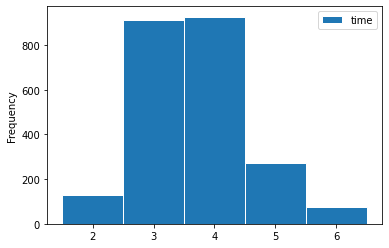

In [52]:
df.plot(kind='hist', by='time', ec='w', bins=np.arange(1.5, 6.6, 1))

In [53]:
df.get(['time']).mean()

time    3.672429
dtype: float64

In [55]:
bot = SquabbleBot(word_array)
guess = bot.get_guess()
print(guess)

while guess.size > 1:
    guess = bot.get_guess()
    print(guess)

What did you guess?alert
And what were the values?10100
           value
word            
chase  15.081967
sauce  14.672131
space  14.672131
cause  14.672131
shave  14.590164
What did you guess?chase
And what were the values?20122
       value
word        
cause   25.0


5